# Large-Scale modeling and analysis of TCR-pMHC

#### I) VDJ -> fasta + clustering
#### II) Run TCRpMHC models on real + negative
#### III) Calculate on Rosetta + FoldX energies
#### IV) Statistics
#### V) Model Quality 

ftp://ftp.ebi.ac.uk/pub/databases/ipd/mhc/

### Import the data into Dataframes

In [42]:
import pandas as pd
import re

infile='SearchTable-2020-02-06 14_18_56.611.tsv'
df=pd.read_table(infile, sep="\t")
infile2='Jgenes_fasta_outfile'
df2=pd.read_table(infile2, sep="|",names=["Name", "Specie","Funct","0", "1","2","3","4","5","6","7","8","9","10","Seq"])
infile3='Vgenes_fasta_outfile.txt'
df3=pd.read_table(infile3, sep="|",names=["Name", "Specie","Funct","0", "1","2","3","4","5","6","7","8","9","10","Seq"])

#df2, df3 not used because Species are written in a different format 

N/As need to be removed as well as all the un-paired TCR and the class II mhc entries

In [ ]:
#First drop N/A
df=df.dropna()

#Then remove the un-paired complex.id 
complex_id_list = list(set(df['complex.id']))
drops=[]
for i in complex_id_list:     
    i=int(i)
    if len(df.loc[df["complex.id"]==i])!=2:    #Because for each TCR there are Alpha and Beta (len==2)
        drops.append(i)

df = df[~df["complex.id"].isin(drops)]
mhcII=list(df.loc[df["MHC class"]=="MHCII", "complex.id"])
df = df[~df["complex.id"].isin(mhcII)]

#df.drop(df.index[df.loc[df["complex.id"]==i].index[0]])

## Statistics/Correlations 

In [184]:
print(len(df.loc[df["Gene"]=="TRA"]))
len(df.loc[df["Gene"]=="TRB"])

21203


21203

This is just to have useful data in variables to be used afterwards

In [189]:
dfAlpha=df[(df['Gene']=='TRA')].iloc[:,[0,1,3,4,5,9]]
VgenesDFA=dfAlpha.iloc[:,[2,3,4]]
JgenesDFA=dfAlpha.iloc[:,[3]]
newA = VgenesDFA["J"].copy()
df6A=VgenesDFA["V"].str.cat(newA, sep ="")
alphaVJ=df6A.value_counts()


dfBeta=df[(df['Gene']=='TRB')].iloc[:,[0,1,3,4,5,9]]
VgenesDFB=dfBeta.iloc[:,[2,3,4]]
newB = VgenesDFB["J"].copy()
JgenesDFB=dfBeta.iloc[:,[3]]
#VgenesBeta=
df6B=VgenesDFB["V"].str.cat(newB, sep ="")
betaVJ=df6B.value_counts()

VgenesBeta=VgenesDFB["V"].copy().unique()
VgenesAlpha=VgenesDFA["V"].copy().unique()
JgenesAlpha=newA.unique()
VgenesAB=VgenesDFA["V"].str.cat(VgenesDFB["V"], sep="")
VgenesAB_counts=VgenesAB.value_counts()
JgenesAB=JgenesDFA["J"].str.cat(JgenesDFB["J"], sep="")
JgenesAB_counts=JgenesAB.value_counts()




/Users/s182286/opt/anaconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: A future version of pandas will perform index alignment when `others` is a Series/Index/DataFrame (or a list-like containing one). To disable alignment (the behavior before v.0.23) and silence this warning, use `.values` on any Series/Index/DataFrame in `others`. To enable alignment and silence this warning, pass `join='left'|'outer'|'inner'|'right'`. The future default will be `join='left'`.
/Users/s182286/opt/anaconda3/envs/myclone/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: A future version of pandas will perform index alignment when `others` is a Series/Index/DataFrame (or a list-like containing one). To disable alignment (the behavior before v.0.23) and silence this warning, use `.values` on any Series/Index/DataFrame in `others`. To enable alignment and silence this warning, pass `join='left'|'outer'|'inner'|'right'`. The future default will be `

### Heatmap of V vs J genes in Alpha and Beta

The data will be normalized with KL divergence (https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810)

In [185]:
def kl_divergence(P, Q):
    
    '''This function returns the value of KL divergence for probabilities P and Q'''
    
    return np.sum(np.where(P != 0, P * np.log(P / Q), 0))

Alpha

In [190]:
count=0
geneCount=dict()
myDict=dict()
GenesV=[]
GenesJ=[]
Counts=[]
maxnum=int(alphaVJ.max())
VAcounts=VgenesDFA["V"].copy().value_counts()
JAcounts=VgenesDFA["J"].copy().value_counts()
tot=alphaVJ.sum()


for V in VgenesAlpha:
    geneCount=dict()
    for J in JgenesAlpha:
        
        value=0
        concat=V+J
        if concat not in alphaVJ.keys():  #Add 0 if they don't appear together, so they are not in alphaVJ
            geneCount[J]=0
            myDict[V]=geneCount
            #Counts.append(0)
        else:
            
            P=(alphaVJ[concat]/tot)
            Pa=VAcounts[V]/tot
            Pb=JAcounts[J]/tot
            Q=(Pa*Pb)
            #p+=P
            #q+=Q
            value=kl_divergence(P,Q)
            
            geneCount[J]=value
            myDict[V]=geneCount
data_VJalpha=pd.DataFrame.from_dict(myDict)


In [193]:
myDict

{'TRBV14*01': {'TRBJ1-1*01': 0.00019461873322081913,
  'TRBJ1-2*01': 0.0008100565667170898,
  'TRBJ2-1*01': -0.0005550705447857004,
  'TRBJ2-7*01': -0.0003909542667634546,
  'TRBJ1-3*01': 0.00035426554600429146,
  'TRBJ2-3*01': -0.00013058209378538142,
  'TRBJ2-5*01': 0.0008035838989013089,
  'TRBJ2-2*01': -0.0002788737165843318,
  'TRBJ1-5*01': -0.00026045612028340596,
  'TRBJ1-4*01': 0.0007088187619525852,
  'TRBJ2-4*01': 4.0035352816521447e-05,
  'TRBJ1-6*01': 6.698366776561279e-05,
  'TRBJ2-6*01': 0,
  'TRBJ1-6*02': 0},
 'TRBV20-1*01': {'TRBJ1-1*01': -0.001766587531304155,
  'TRBJ1-2*01': 0.00030999583997281274,
  'TRBJ2-1*01': 0.002628116244512952,
  'TRBJ2-7*01': 0.0027969896036831522,
  'TRBJ1-3*01': 0.0017400966641044821,
  'TRBJ2-3*01': 0.00037586925083229187,
  'TRBJ2-5*01': -0.0005795087476446612,
  'TRBJ2-2*01': -0.0014686590276603013,
  'TRBJ1-5*01': -0.0010548720542384417,
  'TRBJ1-4*01': -0.0002190901807083722,
  'TRBJ2-4*01': -0.00017395393351977672,
  'TRBJ1-6*01': -0.

AxesSubplot(0.125,0.125;0.62x0.755)


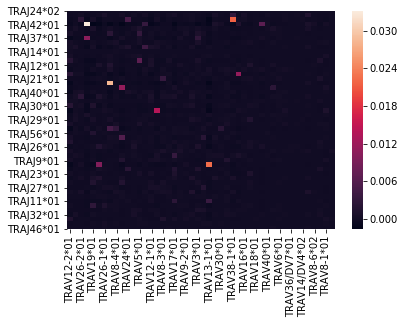

In [146]:
import seaborn as sns
print(sns.heatmap(data_VJalpha))

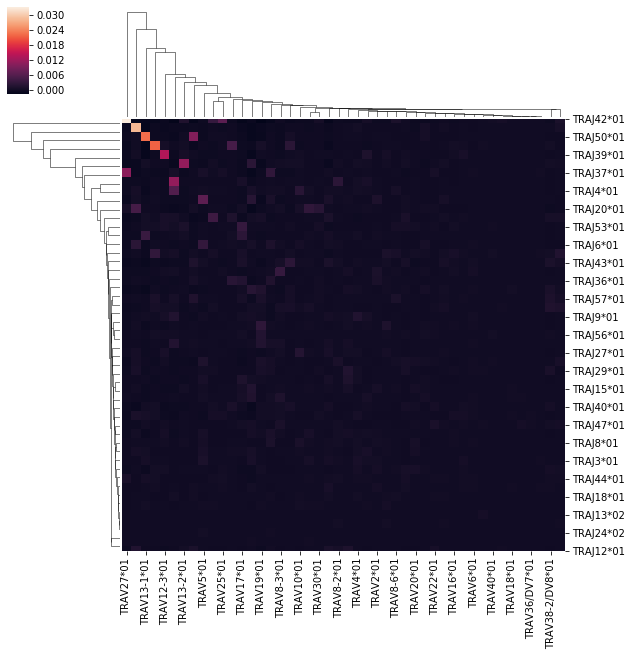

In [152]:
sns_plot=sns.clustermap(data_VJalpha)
sns_plot.savefig("VJalpha.png")

Beta

In [191]:
count=0
geneCount=dict()
myDict=dict()
GenesV=[]
GenesJ=[]
Counts=[]
JgenesBeta=newB.unique()
VgenesBeta=VgenesDFB["V"].copy().unique()
tot=betaVJ.sum()
VBcounts=VgenesDFB["V"].copy().value_counts()
JBcounts=VgenesDFB["J"].copy().value_counts()
concat=""

for V in VgenesBeta:
    geneCount=dict()
    for J in JgenesBeta:
        
        value=0
        concat=V+J
        if concat not in betaVJ.keys():
            geneCount[J]=0
            myDict[V]=geneCount
            #Counts.append(0)
        else:
            
            P=(betaVJ[concat]/tot)
            Pa=VBcounts[V]/tot
            Pb=JBcounts[J]/tot
            Q=(Pa*Pb)
    
            value=kl_divergence(P,Q)
            
            geneCount[J]=value
            myDict[V]=geneCount
data_VJbeta=pd.DataFrame.from_dict(myDict)

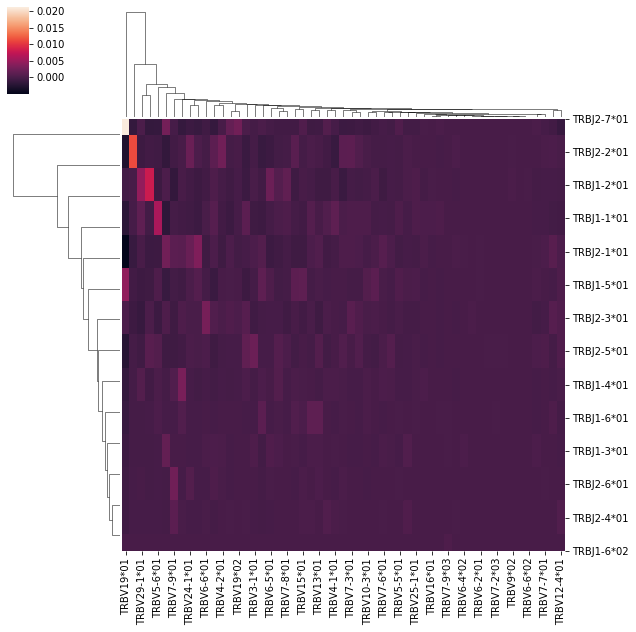

In [153]:
sns_plot=sns.clustermap(data_VJbeta)
sns_plot.savefig("VJbeta.png")

### Heatmap of Vgenes in alpha vs Vgenes in beta

In [192]:

count=0
geneCount=dict()
myDict_AB_Vgenes=dict()
GenesV=[]
GenesJ=[]
Counts=[]
tot=VgenesAB_counts.sum()
Acounts=VgenesDFA["V"].copy().value_counts()
Bcounts=VgenesDFB["V"].copy().value_counts()


for V1 in VgenesAlpha:
    geneCount=dict()
    for V2 in VgenesBeta:
        value=0
        concat=V1+V2
        if concat not in VgenesAB_counts.keys():
            geneCount[V2]=0
            myDict_AB_Vgenes[V1]=geneCount
            #Counts.append(0)x
        else:
            
            P=(VgenesAB_counts[concat]/tot)
            Pa=Acounts[V1]/tot
            Pb=Bcounts[V2]/tot
            Q=(Pa*Pb)
    
            value=kl_divergence(P,Q)
            
            geneCount[V2]=value
            myDict_AB_Vgenes[V1]=geneCount
            
data_1=pd.DataFrame.from_dict(myDict_AB_Vgenes)

#data_1.sort_values('index')
d=data_1.corr()
#sns.heatmap(data_1)

In [155]:
myDict_AB_Vgenes

{'TRAV12-2*01': {'TRBV14*01': 2.8816344956506302e-05,
  'TRBV20-1*01': -0.0003703727246564834,
  'TRBV6-1*01': -0.0003049312700096275,
  'TRBV9*01': -0.0004341539078107042,
  'TRBV6-2*01': 0.00016457930746027375,
  'TRBV29-1*01': -0.0003857136339040266,
  'TRBV6-5*01': 0.00010404243924666804,
  'TRBV2*01': -6.781850477569625e-05,
  'TRBV19*01': 0.0016651849851236258,
  'TRBV7-2*01': 0.00029614822126223855,
  'TRBV11-2*01': 0.00037993222280230014,
  'TRBV6-9*01': 0,
  'TRBV24-1*01': -0.00029956151719455265,
  'TRBV5-1*01': -0.0001966264864130111,
  'TRBV12-3*01': 0.0005025298373973221,
  'TRBV5-5*01': -0.00018470093305004062,
  'TRBV16*01': -3.142518095792297e-05,
  'TRBV30*01': 1.929826730255726e-05,
  'TRBV6-4*01': 0.0003208272465267433,
  'TRBV7-3*01': 8.737345877375578e-05,
  'TRBV7-8*01': -0.00022785459579256726,
  'TRBV10-3*01': -5.129636945372361e-05,
  'TRBV7-9*01': -0.0005768489073600567,
  'TRBV9*02': 0,
  'TRBV12-4*01': -0.00011300555272867311,
  'TRBV4-1*01': 0.0002435982497

In [172]:
print(VgenesAB_counts.max()/VgenesAB_counts.sum())
VgenesAB_counts.sum()

0.010611705890675848


21203

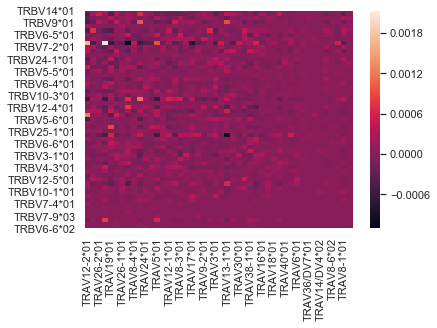

In [555]:
sns.heatmap(data_1)

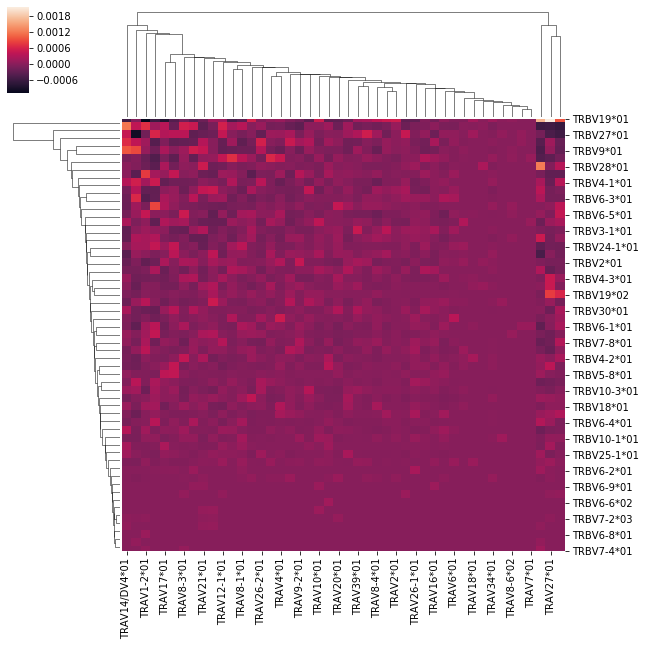

In [156]:
sns.clustermap(data_1)

### Heatmap J genes in Alpha vs Beta

In [174]:

count=0
geneCount=dict()
myDict_AB_Jgenes=dict()
GenesV=[]
GenesJ=[]
Counts=[]
tot=VgenesAB_counts.sum()
Acounts=VgenesDFA["J"].copy().value_counts()
Bcounts=VgenesDFB["J"].copy().value_counts()
#JgenesAB_counts
p=[]
q=[]


for V1 in JgenesAlpha:
    geneCount=dict()
    for V2 in JgenesBeta:
        value=0
        concat=V1+V2
        if concat not in JgenesAB_counts.keys():
            geneCount[V2]=0
            myDict_AB_Jgenes[V1]=geneCount
            #Counts.append(0)x
        else:
            
            P=(JgenesAB_counts[concat]/tot)
            Pa=Acounts[V1]/tot
            Pb=Bcounts[V2]/tot
            Q=(Pa*Pb)
            p.append(P)
            q.append(Q)
            value=kl_divergence(P,Q)
            #value=VgenesAB_counts[concat]
            geneCount[V2]=value
            myDict_AB_Jgenes[V1]=geneCount
            
Jgenes_AB=pd.DataFrame.from_dict(myDict_AB_Jgenes)

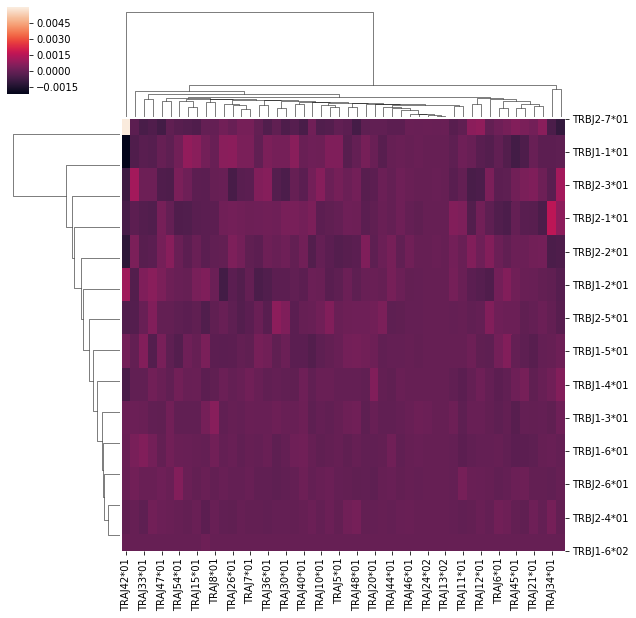

In [179]:
sns_plot1=sns.clustermap(Jgenes_AB)
sns_plot1.savefig("JAlphaBeta.png")


## V/J genes from IMGT/Gene-DB
First, the input files are treated so the data will be extracted easily afterwards


In [194]:
import re

infile=open('Vgenes_fasta.txt','r')
outfile=open('Vgenes_fasta_outfile.txt','w')
header=""
line1=""
finalVgene=""

#This will put gene in a line called line1 to make it easier
for line in infile:
    if line.startswith(">"):
        
        
        if len(line1)>0:
            #print(line1[:104])
            lastChar=line1[:104]
            
            #Check for Functional V genes only and the entries that finish with the Cystein
            if headerTest[3]=="F" and lastChar[-1]=="C":
            
                final_Vgene=lastChar.replace(".","")
                print(header + final_Vgene, file=outfile)     
                #print(header + final_Vgene)
                #print(header)
            line1=""
            header=line.strip()

        else:
            headerTest=line[:-1].split("|")
            header=line.strip() 
            
            
    else:
        
        line1+=line.strip()


To put the J genes in the same line

In [195]:
import re

infile=open('Jgenes_fasta.txt','r')
outfile=open('Jgenes_fasta_outfile','w')

header=""
Jgene=""
for line in infile:
    
    if line.startswith('>'):
        if len(header)>0:
            result=re.search("\w+[FW](G.G\w+)$",Jgene)
            if result is not None:
                Jgene_processed=result.group(1)
                print(header +  Jgene_processed, file=outfile)
                #print(Jgene_processed, file=outfile2)
            header=""
            Jgene=""
            header=line.strip()
        else:
            header=line.strip()
    else:    
        Jgene=line.strip()


### To create a dict for Jgenes and sequences

In [39]:

infile=open('Jgenes_fasta_outfile','r')

JgenesDict=dict()
spCount=[]
gnCount=[]
Species=dict()
for line in infile:
    line1=line.split("|")
    gene=line1[1]
    specie=line1[2].split("_")[0].lower().replace(" ","")   #Put the species in the same format
    sequence=line1[-1].strip()
    
    if specie not in spCount:     #This was to check the amount of genes, species and how did they look
        spCount.append(specie)
    if specie not in gnCount:
        gnCount.append(gene)
    
    Species=dict()
    if specie not in JgenesDict.keys():
        if gene not in Species.keys():
            Species[gene]=sequence
            JgenesDict[specie]=Species
        else:
            continue
    else:
        if gene not in Species.keys():
            #Species[gene]=sequence
            JgenesDict[specie][gene]=sequence
        else:
            continue

infile.close()



Basic Statistics performed to the length of the J gene sequences

In [40]:
Jgene_seq=[]
Jgene_length=[]
for i in JgenesDict.keys():
    for ii in JgenesDict[i].keys():
        Jgene_seq.append(JgenesDict[i][ii])
        Jgene_length.append(len(JgenesDict[i][ii]))
sq = np.array(Jgene_seq)
ln =np.array(Jgene_length)

#Order statistics
print("The min of the length from J genes is", np.amin(ln))
print("The max of the length from J genes is", np.amax(ln))
print("The range of values (maximum - minimum) along an axis is:",np.ptp(ln))

#Averages
print("The mean of the length from J genes is:", np.mean(ln))
print("The average of the length from J genes is:", np.average(ln))
print("The median of the length from J genes is:",np.median(ln))
print("The standard deviation of the length from J genes is:", np.std(ln))

The min of the length from J genes is 7
The max of the length from J genes is 12
The range of values (maximum - minimum) along an axis is: 5
The mean of the length from J genes is: 9.810040705563093
The average of the length from J genes is: 9.810040705563093
The median of the length from J genes is: 10.0
The standard deviation of the length from J genes is: 0.46214310925432234


### To create a dict for Vgenes and sequences

In [3]:


infile=open('Vgenes_fasta_outfile.txt','r')

VgenesDict=dict()
spCount=[]
gnCount=[]
Species=dict()

for line in infile:
    
    line1=line.split("|")
    gene=line1[1]
    specie=line1[2].split("_")[0].lower().replace(" ","")
    sequence=line1[-1].strip()
    
    if specie not in spCount:
        spCount.append(specie)
    if gene not in gnCount:
        gnCount.append(gene)

    #"""
    Species=dict()
    if specie not in VgenesDict.keys():
        if gene not in Species.keys():
            Species[gene]=sequence
            VgenesDict[specie]=Species
        else:
            continue
    else:
        if gene not in Species.keys():
            #Species[gene]=sequence
            VgenesDict[specie][gene]=sequence
        else:
            continue
    
    #"""       
infile.close()

 


Basic statistics performed to V gene sequences

In [36]:
Vgene_seq=[]
Vgene_length=[]
for i in VgenesDict.keys():
    for ii in VgenesDict[i].keys():
        Vgene_seq.append(VgenesDict[i][ii])
        Vgene_length.append(len(VgenesDict[i][ii]))
sq = np.array(Vgene_seq)
ln =np.array(Vgene_length)

#Order statistics
print("The min of the length from V genes is", np.amin(ln))
print("The max of the length from V genes is", np.amax(ln))
print("The range of values (maximum - minimum) along an axis is:",np.ptp(ln))

#Averages
print("The mean of the length from V genes is:", np.mean(ln))
print("The average of the length from V genes is:", np.average(ln))
print("The median of the length from V genes is:",np.median(ln))
print("The standard deviation of the length from V genes is:", np.std(ln))

The min of the length from V genes is 24
The max of the length from V genes is 98
The range of values (maximum - minimum) along an axis is: 74
The mean of the length from V genes is: 90.56598240469208
The average of the length from V genes is: 90.56598240469208
The median of the length from V genes is: 91.0
The standard deviation of the length from V genes is: 3.9517243458588123


## TCR construction

Now that V and J are in Dicts, tha V can be added before the TRA/TRB of the CDR3, generating the whole sequence

In [568]:
complex_id_list = list(set(df['complex.id']))
len(complex_id_list)

21203

In [198]:
import bcr_models as bcr
import bcr_models.utils
import bcr_models.canonical_structures


hmms = bcr.db.builtin_hmms()
template_db = bcr.db.BuiltinTemplateDatabase()
pdb_db = bcr.db.BuiltinPDBDatabase()


#To construct the whole sequences
outfile=open('Sequences_TCR','w')
outfile1=open('alpha.fasta','w')
outfile2=open('beta.fasta','w')
outfile_alpha=open('TCR_alpha_aligned','w')
outfile_beta=open('TCR_beta_aligned','w')
SeqDict=dict()
lenDictA=[]
lenDictB=[]
Err=[]
compID_list=[]
complex_id_list = list(set(df['complex.id']))

#for i in range(0,len(complex_id_list)-1):
for i in range(0,100): #This is to test
    
    i=int(complex_id_list[i])
    
    if len(df.loc[(df['complex.id']==i)])==2:
        
        TRA=""
        TRB=""
        specie=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'Species'].iloc[0].lower()
        VgeneA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'V'].iloc[0]
        VgeneB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'V'].iloc[0]
        JgeneA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'J'].iloc[0]
        JgeneB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'J'].iloc[0]
        CDRA=df.loc[(df['complex.id']==i) & (df['Gene']=='TRA'),'CDR3'].iloc[0]
        CDRB=df.loc[(df['complex.id']==i) & (df['Gene']=='TRB'),'CDR3'].iloc[0]
        
        items1=VgeneA,VgeneB
        items2=JgeneA,JgeneB
        #To make sure the specie is present in both dictionaries
        if all(i in VgenesDict[specie].keys() for i in items1):
            if all(y in JgenesDict[specie].keys() for y in items2):
               
                VgeneSeqA=VgenesDict[specie][VgeneA]
                VgeneSeqB=VgenesDict[specie][VgeneB]
                JgeneSeqA=JgenesDict[specie][JgeneA]
                JgeneSeqB=JgenesDict[specie][JgeneB]
                
                #Put the sequences together
                TRA=VgeneSeqA+CDRA+JgeneSeqA 
                TRB=VgeneSeqB+CDRB+JgeneSeqB
                
                #Code for the hmm alignment
                Ig_A=bcr.IgChain(TRA,template_db=template_db, pdb_db=pdb_db)
                Ig_B=bcr.IgChain(TRB,template_db=template_db, pdb_db=pdb_db)
                
                try:
                    Ig_A.hmmsearch(*hmms)
                    Ig_B.hmmsearch(*hmms)
                except:
                    Err.append(i)
                    next
                TRA_aligned=Ig_A.aligned_seq
                TRB_aligned=Ig_B.aligned_seq
                
                if TRA_aligned is not None:
                    if TRB_aligned is not None:
                        
                        #check for lower case:
                        lc = re.compile('[a-z]+')
                        resultA = lc.findall(TRA_aligned)
                        resultB = lc.findall(TRB_aligned)
                        if not resultA:
                            if not resultB:
                                #So there are no lower case letters
                                SeqDict[i]={"TRA":TRA_aligned, "TRB":TRB_aligned}
                                print(">",i,TRA_aligned, file=outfile_alpha)
                                print(">",i,TRB_aligned, file=outfile_beta)
                                compID_list.append(i)
                                
                                #This list will be used to do basic statistics to the sequences built
                                lenDictA.append(len(TRA))
                                lenDictB.append(len(TRB))
                                
                                
                #print(i,"\t",TRA,"\t",TRB , file=outfile)
                #print(">"+str(i)+"alpha"+"\n"+TRA, file=outfile1)
                #print(">"+str(i)+"beta"+"\n"+TRB, file=outfile2)
            else:
                continue


Basic statistics performed to the TRA and TRB sequences built

In [199]:
#Order statistics
print("Min of the length from TRA is", np.amin(lenDictA), "and from TRB is",np.amin(lenDictB))
print("Max of the length from TRA is", np.amax(lenDictA), "and from TRB is", np.amax(lenDictB))
print("The range of values (maximum - minimum) along an axis is in TRA",np.ptp(lenDictA), "in TRB", np.ptp(lenDictB))

#Averages
print("The mean of TRA is:", np.mean(lenDictA), "and TRB", np.mean(lenDictB))
print("The median of the length from TRA is:",np.median(lenDictA), "and TRB",np.median(lenDictB))
print("The standard deviation of the length from TRA is:", np.std(lenDictA), "and TRB", np.std(lenDictB))

Min of the length from TRA is 108 and from TRB is 111
Max of the length from TRA is 116 and from TRB is 119
The range of values (maximum - minimum) along an axis is in TRA 8 in TRB 8
The mean of TRA is: 111.64406779661017 and TRB 114.66101694915254
The median of the length from TRA is: 111.0 and TRB 114.0
The standard deviation of the length from TRA is: 1.8844835813253922 and TRB 1.6935587792266844


### TO CALCULATE THE SCORE/EXACT MATCHES BETWEEN SEQUENCES IN THE ALIGNMENT

In [627]:
Err

[2,
 7,
 8,
 12,
 20,
 21,
 23,
 25,
 26,
 32,
 33,
 34,
 46,
 50,
 60,
 62,
 64,
 70,
 93,
 102,
 105,
 107,
 114,
 117,
 123,
 124,
 141,
 142,
 145,
 146,
 165,
 166,
 168,
 173,
 174,
 175,
 181,
 182,
 187,
 188,
 189]

In [628]:
print(len(df.loc[df["MHC class"]=="MHCI"]))
len(df.loc[df["MHC class"]=="MHCII"])

42406


0

### TCR Matrix

In [200]:
AlphaCDR3=[]
BetaCDR3=[]
for compID in compID_list:
    lenDictA.append(len(df.loc[(df["Gene"]=="TRA") & (df["complex.id"]==int(compID)),"CDR3"].iloc[0]))
    lenDictB.append(len(df.loc[(df["Gene"]=="TRB") & (df["complex.id"]==int(compID)),"CDR3"].iloc[0]))

#Order statistics
print("Min of the length from CDRA is", np.amin(lenDictA), "and from CDRB is",np.amin(lenDictB))
print("Max of the length from CDRA is", np.amax(lenDictA), "and from CDRB is", np.amax(lenDictB))
print("The range of values (maximum - minimum) along an axis is in CDRA",np.ptp(lenDictA), "in CDRB", np.ptp(lenDictB))

#Averages
print("The mean of CDRA is:", np.mean(lenDictA), "and CDRB", np.mean(lenDictB))
print("The median of the length from CDRA is:",np.median(lenDictA), "and CDRB",np.median(lenDictB))
print("The standard deviation of the length from CDRA is:", np.std(lenDictA), "and CDRB", np.std(lenDictB))
    

Min of the length from CDRA is 10 and from CDRB is 11
Max of the length from CDRA is 116 and from CDRB is 119
The range of values (maximum - minimum) along an axis is in CDRA 106 in CDRB 108
The mean of CDRA is: 62.152542372881356 and CDRB 64.16101694915254
The median of the length from CDRA is: 62.0 and CDRB 64.0
The standard deviation of the length from CDRA is: 49.523428305837825 and CDRB 50.52084153568989


## To build the matrices (dicts) with the sequence ID

In [93]:
#length of the CDR3 will be 22, from there, localize the initial pposition and calculate the score from that

a="----EQSPQFLSIQEGENLTVYCNSSSV--------FSSLQWYRQE-PGEGPVLLVTVVT----GGEVKK-L-KRLTFQF-G-DARKDSSLHITAAQPGDTGLYLCCAGNN------------ARLMFGDGTQLVVKP"
lengthCDR_Alpha=len("CAGNN------------ARLMF")
startposAligned_Alpha=a.find("CAG")
b="-GVTQTPKHLITATGQRVTLRCSPRS------GDLSVYWYQQSLDQGLQFLIQYYNGEERA-------KGNILERFSAQQFPDLHSELNLSSLELGDSALYFCCASSV---------------GNEQFFGPGTRLTVL"
lengthCDR_Beta=len("CASSV---------------GNEQFF")
startposAligned_Beta=b.find("CAS")

#Calculate score for all lines

#for i in range(0,len(complex_id_list)-1):
def seq_ID_CDR(cdr1,cdr2):
    '''This function calculate the sequence ID of 2 strings, only adding 1 with exact match different than insertions. The result is normalized by the longest length'''
    #Calculate the length of the CDR3
    length_longest = max([len(cdr1)-cdr1.count("-"), len(cdr2)-cdr2.count("-")])
    seqID=0
    for pos in range(0,len(cdr1)-1):
        if cdr1[pos:pos+1]==cdr2[pos:pos+1] and cdr1[pos:pos+1]!="-":
            seqID+=1
    return seqID/length_longest

#Alpha
CDR2_A=dict()
CDR2_B=dict()
CDR2_nA=dict()
CDR2_nB=dict()
CDR_Alpha=dict()
CDR_Beta=dict()
nCDR_Alpha=dict()
nCDR_Beta=dict()

for C_ID1 in SeqDict.keys():
    CDR2_A=dict()
    CDR2_B=dict()
    CDR2_nA=dict()
    CDR2_nB=dict()
    for C_ID2 in SeqDict.keys():
        
        #Sanity check for Cys in CDR sequences
       
        #Alpha CDR
        cdr1_A=SeqDict[C_ID1]["TRA"][startposAligned_Alpha:startposAligned_Alpha+lengthCDR_Alpha]
        cdr2_A=SeqDict[C_ID2]["TRA"][startposAligned_Alpha:startposAligned_Alpha+lengthCDR_Alpha]
        if cdr1_A.startswith("C") and cdr2_A.startswith("C"):    
            value_A=seq_ID_CDR(cdr1_A,cdr2_A)
            CDR2_A[C_ID2]=value_A
            CDR_Alpha[C_ID1]=CDR2_A
        
        #Alpha non CDR
        cdr1_nA=SeqDict[C_ID1]["TRA"][0:startposAligned_Alpha-1]
        cdr2_nA=SeqDict[C_ID2]["TRA"][0:startposAligned_Alpha-1]
        value_nA=seq_ID_CDR(cdr1_nA,cdr2_nA)
        CDR2_nA[C_ID2]=value_nA
        nCDR_Alpha[C_ID1]=CDR2_nA
        
        #Beta CDR
        cdr1_B=SeqDict[C_ID1]["TRB"][startposAligned_Beta:startposAligned_Beta+lengthCDR_Beta]
        cdr2_B=SeqDict[C_ID2]["TRB"][startposAligned_Beta:startposAligned_Beta+lengthCDR_Beta]
        if cdr1_B.startswith("C") and cdr2_B.startswith("C"):    
            value_B=seq_ID_CDR(cdr1_B,cdr2_B)
            CDR2_B[C_ID2]=value_B
            CDR_Beta[C_ID1]=CDR2_B
        
        #Alpha non CDR
        cdr1_nB=SeqDict[C_ID1]["TRB"][0:startposAligned_Beta-1]
        cdr2_nB=SeqDict[C_ID2]["TRB"][0:startposAligned_Beta-1]    
        value_nB=seq_ID_CDR(cdr1_nB,cdr2_nB)
        CDR2_nB[C_ID2]=value_nB
        nCDR_Beta[C_ID1]=CDR2_nB
        
        
  


In [121]:
pd.DataFrame.from_dict(CDR_Beta)

,5,6,9,10,13,14,15,16,17,18,...,150,156,157,158,159,160,164,169,170,171
5,0.923077,0.923077,0.076923,0.076923,0.153846,0.428571,0.357143,0.769231,0.769231,0.076923,...,0.142857,0.153846,0.153846,0.153846,0.153846,0.076923,0.200000,0.076923,0.076923,0.071429
6,0.923077,0.923077,0.076923,0.076923,0.153846,0.428571,0.357143,0.769231,0.769231,0.076923,...,0.142857,0.153846,0.153846,0.153846,0.153846,0.076923,0.200000,0.076923,0.076923,0.071429
9,0.076923,0.076923,0.909091,0.909091,0.250000,0.214286,0.214286,0.076923,0.076923,0.461538,...,0.214286,0.461538,0.461538,0.461538,0.461538,0.272727,0.466667,0.461538,0.461538,0.357143
10,0.076923,0.076923,0.909091,0.909091,0.250000,0.214286,0.214286,0.076923,0.076923,0.461538,...,0.214286,0.461538,0.461538,0.461538,0.461538,0.272727,0.466667,0.461538,0.461538,0.357143
13,0.153846,0.153846,0.250000,0.250000,0.916667,0.214286,0.214286,0.153846,0.153846,0.230769,...,0.285714,0.384615,0.384615,0.384615,0.384615,0.166667,0.200000,0.384615,0.384615,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.076923,0.076923,0.272727,0.272727,0.166667,0.071429,0.071429,0.076923,0.076923,0.230769,...,0.142857,0.384615,0.384615,0.384615,0.384615,0.909091,0.200000,0.307692,0.307692,0.357143
164,0.200000,0.200000,0.466667,0.466667,0.200000,0.333333,0.266667,0.133333,0.133333,0.266667,...,0.333333,0.466667,0.466667,0.400000,0.466667,0.200000,0.933333,0.333333,0.333333,0.333333
169,0.076923,0.076923,0.461538,0.461538,0.384615,0.142857,0.142857,0.153846,0.153846,0.461538,...,0.285714,0.615385,0.615385,0.615385,0.615385,0.307692,0.333333,0.923077,0.923077,0.500000
170,0.076923,0.076923,0.461538,0.461538,0.384615,0.142857,0.142857,0.153846,0.153846,0.461538,...,0.285714,0.615385,0.615385,0.615385,0.615385,0.307692,0.333333,0.923077,0.923077,0.500000


In [94]:
print(len(cdr1_A), len(cdr2_A))
print(len(cdr1_nA), len(cdr2_nA))
print(len(cdr1_B), len(cdr2_B))
print(len(cdr1_nB), len(cdr2_nB))

22 22
105 105
26 26
102 102


### Peptide Matrix (aligment + seqID)

In [97]:
import pandas as pd
import numpy as np 
import sys
import pickle
sys.path.insert(0,'/home/frisa/software/')
#import SequenceClustering
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import sys


def get_seqid(seq1, seq2):
    length_shortest = len(min([seq1, seq2], key=len))
    pairwise_align = pairwise2.align.globalms(seq1, seq2, 1, -1, -2.5, -.3, one_alignment_only=True)
    #print(pairwise_align)
    
    seqid = 0 
    for n, aa in enumerate(pairwise_align[0][0]):
        if aa == pairwise_align[0][1][n]:
            seqid += 1
    
    return seqid/length_shortest 


In [205]:
#df["Epitope"].describe()

#Epitopes from the complexId in the compID_list (to make sure all complex ID are the ones that we have the alignment of the TCRs)
AlphaEpitopes=[]
BetaEpitopes=[]
for compID in compID_list:
    AlphaEpitopes.append(df.loc[(df["Gene"]=="TRA") & (df["complex.id"]==int(compID)),"Epitope"].iloc[0])
    BetaEpitopes.append(df.loc[(df["Gene"]=="TRB") & (df["complex.id"]==int(compID)),"Epitope"].iloc[0])

#Alpha 
testList=AlphaEpitopes[0:10] #Only to try if code works
peptide2=dict()
peptidesAlpha=dict()
for pep1 in AlphaEpitopes:
    peptide2=dict()
    for pep2 in AlphaEpitopes:
        value=get_seqid(pep1,pep2)
        peptide2[pep2]=value
        peptidesAlpha[pep1]=peptide2

#Beta       
testListB=BetaEpitopes[0:10] 
peptide2=dict()
peptidesBeta=dict()
for pep1 in BetaEpitopes:
    peptide2=dict()
    for pep2 in BetaEpitopes:
        value=get_seqid(pep1,pep2)
        peptide2[pep2]=value
        peptidesBeta[pep1]=peptide2
        

In [ ]:
pep_Alpha_len=[]
for i in range(0,len(AlphaEpitopes)-1):
    pep_Alpha_len.append(len(AlphaEpitopes[i]))
ln =np.array(pep_Alpha_len)

pep_Beta_len=[]
for i in range(0,len(BetaEpitopes)-1):
    pep_Beta_len.append(len(BetaEpitopes[i]))
le =np.array(pep_Beta_len)

#They have to be the same, just as a sanity check

#Order statistics
print("The min of the length of peptidesA is", np.amin(ln),"for peptidesB is", np.amin(le))
print("The max of the length of peptidesA is", np.amax(ln),"for peptidesB is", np.amax(le))
print("The range of values (maximum - minimum) along an axis is:",np.ptp(ln),"for peptidesB is", np.ptp(le))

#Averages
print("The mean of the length of peptidesA is:", np.mean(ln),"for peptidesB is", np.mean(le))
print("The median of the length of peptidesA is:",np.median(ln),"for peptidesB is", np.median(le))
print("The standard deviation of the length of peptidesA is:", np.std(ln),"for peptidesB is", np.std(le))

Use peptidesAlpha or peptidesBeta, they are the same

## Extract the MHC sequences 


Reorganize MHC and put the sequence together in one line

In [389]:
infile_MHC=open("MHC_prot.fasta","r")
outfile=open("MHC_prot_reorg.fasta","w")

line1=""
for line in infile_MHC:
    if line.startswith(">"):
        if len(line1)>0:
            print(header+line1, file=outfile)
            #print(line1, file=outfile)
            header=""
            line1=""
            header=line
        else:
            header=line
    else:
        line1+=line[:-1]
infile_MHC.close()        
outfile.close()
#print(next(infile_MHC))

put the MHC sequences from the ones that can find

In [653]:
MHC_list=df.iloc[:,6].unique()
#df.iloc[:,6].value_counts()

In [62]:
MHC_ALL=df.iloc[:,[0,1,6]]
Alpha_MHC=MHC_ALL.loc[df["Gene"]=="TRA", "MHC A"].unique()
Beta_MHC=MHC_ALL.loc[df["Gene"]=="TRB", "MHC A"].unique()

In [60]:
MHC_ALL.loc[df["Gene"]=="TRB", "MHC A"].value_counts()

HLA-A*03:01             13815
HLA-A*02:01              3393
HLA-A*11:01              2384
HLA-B*08:01              1243
HLA-A*02                  153
HLA-A*24:02                68
HLA-DRA*01:01              54
HLA-B*07:02                36
HLA-A*02:01:48             19
HLA-B*35:01                18
HLA-B*08                   18
HLA-B*35:08                18
HLA-A*11                   17
HLA-B*51:01                16
HLA-DRA*01:02:03            7
HLA-B*07                    7
HLA-B*35:08:01              6
HLA-B*35:42:01              5
HLA-B*08:01:29              4
HLA-DRA*01:01:02            3
HLA-DQA1*05:01:01:02        3
HLA-A*24:02:84              3
HLA-B*44:05:01              3
HLA-A*02:01:59              3
HLA-DQA1*03:01:01           3
HLA-B*27:05:31              2
HLA-A*01:01                 2
HLA-A*02:01:98              2
HLA-B*57:06                 1
HLA-B*12                    1
HLA-B*51:193                1
HLA-E*01:01:01:03           1
HLA-B*44:05                 1
HLA-A*02:0

### Alpha MHC

In [63]:
Alpha_MHC

array(['HLA-A*02:01:59', 'HLA-A*02:01:48', 'HLA-DRA*01:02:03',
       'HLA-B*08:01:29', 'HLA-B*35:08:01', 'HLA-E*01:01:01:03',
       'HLA-DRA*01:01:02', 'HLA-B*35:42:01', 'HLA-B*57:06',
       'HLA-B*44:05:01', 'HLA-A*02:01:98', 'HLA-A*24:02:84',
       'HLA-B*27:05:31', 'HLA-DQA1*03:01:01', 'HLA-B*51:193',
       'HLA-DQA1*05:01:01:02', 'HLA-A*02:01:110', 'HLA-A*02',
       'HLA-B*35:01', 'HLA-B*35:08', 'HLA-A*02:01', 'HLA-B*12',
       'HLA-B*08:01', 'HLA-A*11:01', 'HLA-B*07:02', 'HLA-B*08',
       'HLA-B*07', 'HLA-A*01:01', 'HLA-B*51:01', 'HLA-A*03:01',
       'HLA-B*44:05', 'HLA-A*11', 'HLA-A*24:02', 'HLA-DRA*01:01'],
      dtype=object)

In [78]:

outfile=open("MHCseq1_Alpha","w")
myMHC_Alpha=dict()
MHC_not_present=[]
MHC_modified=[]
#ADD THE MHC_MODIFIED to MHC list so that it searches for the name search

for i in Alpha_MHC:
#for i in ['HLA-A*02:01','HLA-B*07:02']:
    s=i.split("-")
    MHCname=s[1]
    #print(MHCname)
    longest=0

    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC
    MHCseq=""
    for line in infile_MHC_reorg:
        
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)    
                    if MHCname not in myMHC_Alpha:
                        if MHCname.count(":")>0:
                            myMHC_Alpha[MHCname]=MHCseq[:-1]
                        #print(MHCname)
                    else:
                        continue
                    print(">",MHCname, file=outfile)
                    print(MHCseq, file=outfile)
                else:
                    MHCseq=""
            
    infile_MHC_reorg.close()
    
    if MHCseq =="":
        MHC_not_present.append(MHCname)
        if MHCname.count(":")==1:
            print(MHCname, "cannot be modified")
        elif MHCname.count(":")>=2:
            stri=MHCname.split(":")
            MHCname1=stri[0]+":"+stri[1]
            if MHCname1 not in MHC_modified: 
                MHC_modified.append(MHCname1)
            else:
                continue
                
for MHCname in MHC_modified:           
    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC modified
    MHCseq=""
    for line in infile_MHC_reorg:
    
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)   
                    if MHCname not in myMHC_Alpha:
                        if MHCname.count(":")>0:
                            myMHC_Alpha[MHCname]=MHCseq[:-1]
                    else:
                        continue
                    #print(">",MHCname, file=outfile)
                    #print(MHCseq, file=outfile)
                else:
                    MHCseq=""
        
            
    infile_MHC_reorg.close()


B*57:06 cannot be modified
B*51:193 cannot be modified
B*35:08 cannot be modified
B*44:05 cannot be modified
A*24:02 cannot be modified


In [79]:
MHC_Alpha_len=[]
for i in myMHC_Alpha:
    MHC_Alpha_len.append(len(myMHC_Alpha[i]))
ln =np.array(MHC_Alpha_len)

#Order statistics
print("The min of the length from V genes is", np.amin(ln))
print("The max of the length from V genes is", np.amax(ln))
print("The range of values (maximum - minimum) along an axis is:",np.ptp(ln))

#Averages
print("The mean of the length from V genes is:", np.mean(ln))
print("The average of the length from V genes is:", np.average(ln))
print("The median of the length from V genes is:",np.median(ln))
print("The standard deviation of the length from V genes is:", np.std(ln))

The min of the length from V genes is 181
The max of the length from V genes is 365
The range of values (maximum - minimum) along an axis is: 184
The mean of the length from V genes is: 310.5
The average of the length from V genes is: 310.5
The median of the length from V genes is: 355.5
The standard deviation of the length from V genes is: 62.904027428032514


In [77]:
outfile=open("mhc.fasta","w")
for m in myMHC.keys():
    print(">",m, file=outfile)
    print(myMHC[m], file=outfile)

#### Alignment of MHC sequences (HMM)
ftp://ftp.ebi.ac.uk/pub/databases/Pfam/releases/Pfam33.1/database_files/
HMM from TCR-pMHC complexes

hmmalign --outformat a2m --trim MHC_I_complete.hmm mhc_alpha.fasta > MHC_alpha_aligned.txt
hmmalign --outformat a2m --trim MHC_I_complete.hmm mhc_beta.fasta > MHC_beta_aligned.txt

In [661]:

#!ls -lart
#!mv MHC_I_complete.txt MHC_I_complete.hmm

#!hmmalign MHC_I_complete.hmm mhc_beta.fasta

#code for the alignment of MHC sequences

"""hmmalign --outformat a2m --trim MHC_I_complete.hmm mhc.fasta > MHC_aligned.txt """

In [88]:
def seq_ID_MHC(m1,m2):
    #Calculate the length of the CDR3
    length_longest = max([len(m1)-m1.count("-"), len(m2)-m2.count("-")])
    #otherwise make shortest to stop when not to be out of range
    seqID=0
    for pos in range(0,length_longest-1):
        if m1[pos:pos+1]==m2[pos:pos+1] and m1[pos:pos+1]!="-":
            seqID+=1
    return seqID/length_longest

In [85]:
infile=open("MHC_alpha_a.txt","r")
outfile=open("MHC_alpha_aligned.txt","w")
myMHC_Alpha_aligned=dict()
line1=""
for line in infile:
    if line.startswith(">"):
        if len(line1)>0:
            print(header+line1, file=outfile)
            myMHC_Alpha_aligned[header[1:-1]]=line1
            #print(line1, file=outfile)
            header=""
            line1=""
            header=line
        else:
            header=line
    else:
        line1+=line[:-1]
infile.close()        
outfile.close()


In [86]:
myMHC_Alpha_aligned

{'B*35:01': 'GSHSMRYFSTSVSRPGRREPWHLEVGYVDDTQFVRFDSDAESPRLEPRAPWVEQEG-PEYWDRETRIAKANAQTERGNLRTLLRYYNQSEGGSHTIQRMYGCDLGPDGHLLRGYDQSAYDGKDYIALNEDLRSWTAADMTARFTQRKWEAAREAEQ-QRAYLEGKCLEWLRRYLENGKETL',
 'A*02:01': 'GSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEE-PEYWDGETRKVKAHSQTDRVNLGTLRGYYNQSEDGSHTIQKMYGCDVGSDGRFLRGYQQDAYDGKDYIALNEDLRSWTAADMAAEITKRKWEAAHFAEQ-LRAYLEGECVEWLRRYLENGKETL',
 'B*08:01': 'GSHSMRYFSTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRVEPLVPLIEQEG-PEYWDQETQKAKTQAQNDRVSLQNLRGYYNQSEDGSHTWQRMYGCDVGPDGRLLRGYCQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAAREAEQ-LRAYLEGLCVESLRRYLENGKETL',
 'A*11:01': 'GSHSMRYFYTSMSRPGRGQPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWVEQEG-PEYWDRETQNMKAETQSYRENLRTALRYYNQSEAGSHTIQTMYGCDLGPDGRLLRGYEQDAYDGKDYIALNEDLRSWTAADLAAQNTQRKWEAEGWAEQ-VRAYLEGECLESLRRYLENGKETL',
 'B*07:02': 'GSHSMKYFLTSVSRPGRGEPRFITVGYVDDTQFVRFDSDAASPRMEPRAPWIEQEG-PEYWDRETRNVKAFAQTYRENLRIALRYYNQSEDGSHTIQTMFGCDVGPDGRLLRGYRQYAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQ-HRAYLEGLCVEWLRRYLENGKETL',
 'A*01:01': 'GS

In [89]:
#It has to be with the sequences aligned!!
mhc2=dict()
MHCmatrix=dict()
for m1 in myMHC_Alpha_aligned.keys():
    mhc2=dict()
    for m2 in myMHC_Alpha_aligned.keys():
        
        value=seq_ID_MHC(m1,m2)
        mhc2[m2]=value
        MHCmatrix[m1]=mhc2

In [90]:
MHCmatrix

{'B*35:01': {'B*35:01': 0.8571428571428571,
  'A*02:01': 0.42857142857142855,
  'B*08:01': 0.5714285714285714,
  'A*11:01': 0.42857142857142855,
  'B*07:02': 0.5714285714285714,
  'A*01:01': 0.42857142857142855,
  'B*51:01': 0.5714285714285714},
 'A*02:01': {'B*35:01': 0.42857142857142855,
  'A*02:01': 0.8571428571428571,
  'B*08:01': 0.5714285714285714,
  'A*11:01': 0.5714285714285714,
  'B*07:02': 0.5714285714285714,
  'A*01:01': 0.7142857142857143,
  'B*51:01': 0.42857142857142855},
 'B*08:01': {'B*35:01': 0.5714285714285714,
  'A*02:01': 0.5714285714285714,
  'B*08:01': 0.8571428571428571,
  'A*11:01': 0.42857142857142855,
  'B*07:02': 0.7142857142857143,
  'A*01:01': 0.5714285714285714,
  'B*51:01': 0.5714285714285714},
 'A*11:01': {'B*35:01': 0.42857142857142855,
  'A*02:01': 0.5714285714285714,
  'B*08:01': 0.42857142857142855,
  'A*11:01': 0.8571428571428571,
  'B*07:02': 0.42857142857142855,
  'A*01:01': 0.7142857142857143,
  'B*51:01': 0.5714285714285714},
 'B*07:02': {'B*35:

### Beta MHC

In [68]:

outfile=open("MHCseq1_Beta","w")

myMHC_Beta=dict()
MHC_not_present=[]
MHC_modified=[]
#ADD THE MHC_MODIFIED to MHC list so that it searches for the name search

for i in Beta_MHC:
#for i in ['HLA-A*02:01','HLA-B*07:02']:
    s=i.split("-")
    MHCname=s[1]
    #print(MHCname)
    longest=0

    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC
    MHCseq=""
    for line in infile_MHC_reorg:
        
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)    
                    if MHCname not in myMHC_Beta:
                        if MHCname.count(":")>0:
                            myMHC_Beta[MHCname]=MHCseq[:-1]
                        #print(MHCname)
                    else:
                        continue
                    print(">",MHCname, file=outfile)
                    print(MHCseq, file=outfile)
                else:
                    MHCseq=""
            
    infile_MHC_reorg.close()
    
    if MHCseq =="":
        MHC_not_present.append(MHCname)
        if MHCname.count(":")==1:
            print(MHCname, "cannot be modified")
        elif MHCname.count(":")>=2:
            stri=MHCname.split(":")
            MHCname1=stri[0]+":"+stri[1]
            if MHCname1 not in MHC_modified: 
                MHC_modified.append(MHCname1)
            else:
                continue
                
for MHCname in MHC_modified:           
    infile_MHC_reorg=open("MHC_prot_reorg.fasta","r")
    #Check for the longest for each MHC modified
    MHCseq=""
    for line in infile_MHC_reorg:
    
        if MHCname in line:
            line1=line.split(" ")
            if int(line1[2])>longest:
                longest=int(line1[2])
                if longest>0:
                    MHCseq=next(infile_MHC_reorg)   
                    if MHCname not in myMHC_Beta:
                        if MHCname.count(":")>0:
                            myMHC_Beta[MHCname]=MHCseq[:-1]
                        else:
                            continue
                    else:
                        continue
                    #print(">",MHCname, file=outfile)
                    #print(MHCseq, file=outfile)
                else:
                    MHCseq=""
        
            
    infile_MHC_reorg.close()


B*57:06 cannot be modified
B*51:193 cannot be modified
A*24:02 cannot be modified
B*35:08 cannot be modified
B*44:05 cannot be modified


In [69]:
MHC_Beta_len=[]
for i in myMHC_Beta:
    MHC_Beta_len.append(len(myMHC_Beta[i]))
ln =np.array(MHC_Beta_len)

#Order statistics
print("The min of the length from V genes is", np.amin(ln))
print("The max of the length from V genes is", np.amax(ln))
print("The range of values (maximum - minimum) along an axis is:",np.ptp(ln))

#Averages
print("The mean of the length from V genes is:", np.mean(ln))
print("The average of the length from V genes is:", np.average(ln))
print("The median of the length from V genes is:",np.median(ln))
print("The standard deviation of the length from V genes is:", np.std(ln))

The min of the length from V genes is 181
The max of the length from V genes is 365
The range of values (maximum - minimum) along an axis is: 184
The mean of the length from V genes is: 310.5
The average of the length from V genes is: 310.5
The median of the length from V genes is: 355.5
The standard deviation of the length from V genes is: 62.904027428032514


In [669]:
#Print a fasta file
outfile1=open("mhc_beta.fasta","w")
for m in myMHC_Beta.keys():
    print(">",m, file=outfile1)
    print(myMHC_Beta[m], file=outfile1)

To put the aligned sequence in the same line and create a dict with aligned MHC

In [698]:
infile=open("MHC_beta_a.txt","r")
outfile=open("MHC_beta_aligned.txt","w")
myMHC_Beta_aligned=dict()
line1=""
for line in infile:
    if line.startswith(">"):
        if len(line1)>0:
            
            print(header+line1, file=outfile)
            myMHC_Beta_aligned[header[1:-1]]=line1
            #print(line1, file=outfile)
            header=""
            line1=""
            header=line
        else:
            header=line
    else:
        line1+=line[:-1]
infile.close()        
outfile.close()

In [703]:
mhc2=dict()
MHCBeta=dict()
#It has to be with the sequences aligned!!

for m1 in myMHC_Beta_aligned.keys():
    mhc2=dict()
    for m2 in myMHC_Beta_aligned.keys():
        
        value=seq_ID_MHC(m1,m2)
        mhc2[m2]=value
        MHCBeta[m1]=mhc2

In [705]:
MHCBeta

{'A*02:01': {'A*02:01': 0.8571428571428571,
  'B*07:02': 0.5714285714285714,
  'B*51:01': 0.42857142857142855,
  'B*35:01': 0.42857142857142855,
  'A*03:01': 0.7142857142857143,
  'A*11:01': 0.5714285714285714,
  'B*08:01': 0.5714285714285714},
 'B*07:02': {'A*02:01': 0.5714285714285714,
  'B*07:02': 0.8571428571428571,
  'B*51:01': 0.5714285714285714,
  'B*35:01': 0.5714285714285714,
  'A*03:01': 0.5714285714285714,
  'A*11:01': 0.42857142857142855,
  'B*08:01': 0.7142857142857143},
 'B*51:01': {'A*02:01': 0.42857142857142855,
  'B*07:02': 0.5714285714285714,
  'B*51:01': 0.8571428571428571,
  'B*35:01': 0.5714285714285714,
  'A*03:01': 0.42857142857142855,
  'A*11:01': 0.5714285714285714,
  'B*08:01': 0.5714285714285714},
 'B*35:01': {'A*02:01': 0.42857142857142855,
  'B*07:02': 0.5714285714285714,
  'B*51:01': 0.5714285714285714,
  'B*35:01': 0.8571428571428571,
  'A*03:01': 0.42857142857142855,
  'A*11:01': 0.42857142857142855,
  'B*08:01': 0.5714285714285714},
 'A*03:01': {'A*02:0